## Advanced features:

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import folium
import pickle
import datetime

import warnings
warnings.filterwarnings("ignore")

In [30]:
#load the data
data = pd.read_csv("data_with_basic_features.csv")
data.drop("Unnamed: 0",axis=1,inplace=True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113105 entries, 0 to 113104
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113105 non-null  object 
 1   payment_sequential             113105 non-null  int64  
 2   payment_type                   113105 non-null  object 
 3   payment_installments           113105 non-null  int64  
 4   payment_value                  113105 non-null  float64
 5   customer_id                    113105 non-null  object 
 6   order_status                   113105 non-null  object 
 7   order_purchase_timestamp       113105 non-null  object 
 8   order_approved_at              113105 non-null  object 
 9   order_delivered_carrier_date   113105 non-null  object 
 10  order_delivered_customer_date  113105 non-null  object 
 11  order_estimated_delivery_date  113105 non-null  object 
 12  review_score                  

In [32]:
#lets change the datetime features to correct format
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])
data["order_approved_at"] = pd.to_datetime(data["order_approved_at"])
data["order_delivered_carrier_date"] = pd.to_datetime(data["order_delivered_carrier_date"])
data["order_delivered_customer_date"] = pd.to_datetime(data["order_delivered_customer_date"])
data["order_estimated_delivery_date"] = pd.to_datetime(data["order_estimated_delivery_date"])
data["shipping_limit_date"] = pd.to_datetime(data["shipping_limit_date"])


<b> I created seller order_item_id share and customer order_id share features. using this features I want to create similarity between user and seller

<b> This feature is inspired by the research paper https://www.kdd.org/kdd2016/papers/files/adf0160-liuA.pdf

Let NMB be the number of purchases of the brand
from the merchant, NM be the total number of purchases
from the merchant, and NB be the number of purchases of
the brand from all the merchants. Similarly, we define UMB
as the number of users buying the brand from the merchant,
UM the total number of buyers of the merchant, and UB the
number of buyers of the brand from all the merchants. The
following four features are then generated:

* 1) merchant’s market share on the brand = NMB /NB
* 2) merchant’s user share on the brand = UMB/UB
* 3) brand’s market share within the merchant = NMB /NM
* 4) brand’s user share within the merchant = UMB/UM

In [33]:
#groupby order item_id
order_seller = data.groupby("order_item_id")["seller_id"].value_counts().unstack()
order_seller.fillna(0,inplace=True)

total_order_id = np.sum(order_seller,axis=1).to_dict()
total_seller_id = np.sum(order_seller,axis=0).to_dict()

In [6]:
# save the objects to the file
filename="order_seller_table.pkl"
pickle.dump(order_seller,open(filename,"wb"))

filename="total_order_id.pkl"
pickle.dump(total_order_id,open(filename,"wb"))

filename="total_seller_id.pkl"
pickle.dump(total_seller_id,open(filename,"wb"))

In [7]:
#creating feature
seller_share = []
bs_share = []
for i in range(len(data)):
    
     seller_share.append((order_seller.loc[(data["order_item_id"][i],data["seller_id"][i])]/total_order_id[data["order_item_id"][i]]))
    
     bs_share.append((order_seller.loc[(data["order_item_id"][i],data["seller_id"][i])]/total_seller_id[data["seller_id"][i]]))

        
data["seller_share"] = seller_share
data["bs_share"] = bs_share

In [8]:
user_order = data.groupby("order_item_id")["customer_unique_id"].value_counts().unstack()
user_order.fillna(0,inplace=True)

user_total = np.sum(user_order,axis=0).to_dict()
order_total = np.sum(user_order,axis=1).to_dict()

In [9]:
# save the objects to the file
filename="user_order_table.pkl"
pickle.dump(user_order,open(filename,"wb"))

filename="user_total.pkl"
pickle.dump(user_total,open(filename,"wb"))

filename="order_total.pkl"
pickle.dump(order_total,open(filename,"wb"))

In [10]:
cust_share = []
bu_share = []
for i in range(len(data)):
    
    cust_share.append((user_order.loc[(data["order_item_id"][i],data["customer_unique_id"][i])]/order_total[data["order_item_id"][i]]))
    
    bu_share.append((user_order.loc[(data["order_item_id"][i],data["customer_unique_id"][i])]/user_total[data["customer_unique_id"][i]]))
    
    
data["cust_share"] = cust_share
data["bu_share"] = bu_share

In [11]:
#calculating similarity
similarity = []
for i in range(len(data)):
     similarity.append((np.dot([data["seller_share"][i],data["bs_share"][i]] , [data["cust_share"][i],data["bu_share"][i]])))
        
data["similarity"] = similarity

<b> Using product category name

In [12]:
cat_seller = data.groupby("product_category_name")["seller_id"].value_counts().unstack()
cat_seller.fillna(0,inplace=True)

total_cat_order_id = np.sum(cat_seller,axis=1).to_dict()
total_cat_seller_id = np.sum(cat_seller,axis=0).to_dict()


seller_share = []
bs_share = []
for i in range(len(data)):
    
     seller_share.append((cat_seller.loc[(data["product_category_name"][i],data["seller_id"][i])]/total_cat_order_id[data["product_category_name"][i]]))
    
     bs_share.append((cat_seller.loc[(data["product_category_name"][i],data["seller_id"][i])]/total_cat_seller_id[data["seller_id"][i]]))

        
data["seller_category_share"] = seller_share
data["cat_seller_share"] = bs_share




user_cat = data.groupby("product_category_name")["customer_unique_id"].value_counts().unstack()
user_cat.fillna(0,inplace=True)

user_cat_total = np.sum(user_cat,axis=0).to_dict()
order_cat_total = np.sum(user_cat,axis=1).to_dict()


cust_share = []
bu_share = []
for i in range(len(data)):
    
    cust_share.append((user_cat.loc[(data["product_category_name"][i],data["customer_unique_id"][i])]/order_cat_total[data["product_category_name"][i]]))
    
    bu_share.append((user_cat.loc[(data["product_category_name"][i],data["customer_unique_id"][i])]/user_cat_total[data["customer_unique_id"][i]]))

    
data["cust_category_share"] = cust_share
data["cat_cust_share"] = bu_share



#calculating similarity
similarity = []
for i in range(len(data)):
     similarity.append((np.dot([data["seller_category_share"][i],data["cat_seller_share"][i]] , [data["cust_category_share"][i],data["cat_cust_share"][i]])))
        
data["similarity_using_cat"] = similarity

In [13]:
# save the objects to the file
filename="cat_seller_table.pkl"
pickle.dump(cat_seller,open(filename,"wb"))

filename="total_cat_order_id.pkl"
pickle.dump(total_cat_order_id,open(filename,"wb"))

filename="total_cat_seller_id.pkl"
pickle.dump(total_cat_seller_id,open(filename,"wb"))

filename="user_cat_table.pkl"
pickle.dump(user_cat,open(filename,"wb"))

filename="user_cat_total.pkl"
pickle.dump(user_cat_total,open(filename,"wb"))

filename="order_cat_total.pkl"
pickle.dump(order_cat_total,open(filename,"wb"))

## Analysis of new features:

In [14]:
data.corr()[["similarity_using_cat","similarity"]]

,similarity_using_cat,similarity
payment_sequential,-0.005006,-0.015276
payment_installments,0.025927,-0.086158
payment_value,0.041945,-0.195735
review_score,0.001009,0.185706
zip_code_prefix_customer,0.016477,0.014063
lat_customer,0.012423,0.040204
lng_customer,0.005352,0.025916
product_name_lenght,-0.024414,0.015939
product_description_lenght,-0.012010,0.051073
product_photos_qty,-0.149814,0.104617


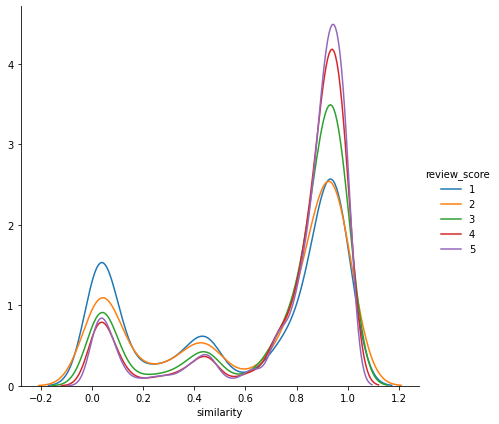

In [15]:
#similarity
sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"similarity")\
    .add_legend()
plt.show()

* This looks good. At low similarity values that is near zero, density  of review_score 1 is high. 
* At high similarity density of review_score 5 and 4 is high. 


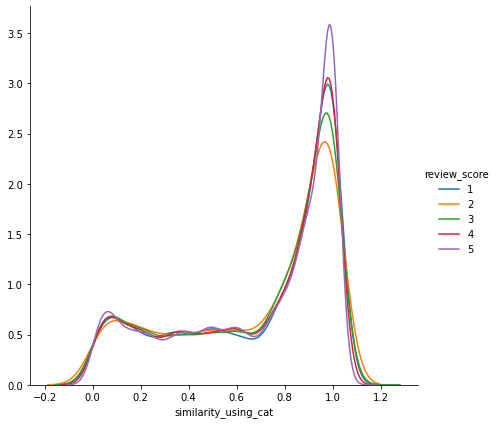

In [12]:
#similarity_using_cat
sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"similarity_using_cat")\
    .add_legend()
plt.show()

* Although review_scores are not clearly separable, At higher similarity values, review_score 5 has high density and review_score 2 has less density.

<b> Size of product

In [16]:
#size of the product
data["size"] = data["product_length_cm"]*data["product_height_cm"]*data["product_width_cm"]

<b> More time based features from time stamps

In [17]:
data["delivery_day"] = data["order_delivered_customer_date"].apply(lambda x: x.weekday())
data["delivery_date"] = data["order_delivered_customer_date"].apply(lambda x: x.day)
data["delivery_month"] = data["order_delivered_customer_date"].apply(lambda x: x.month)
data["delivery_hour"] = data["order_delivered_customer_date"].apply(lambda x: x.hour)

data["purchased_day"] = data["order_purchase_timestamp"].apply(lambda x: x.weekday())
data["purchased_date"] = data["order_purchase_timestamp"].apply(lambda x: x.day)
data["purchased_month"] = data["order_purchase_timestamp"].apply(lambda x: x.month)
data["purchased_hour"] = data["order_purchase_timestamp"].apply(lambda x: x.hour)

<b> Customer user order based features. That is total number of customers per seller and total number of sellers per customers, similarly for orders.

In [18]:
df = data.groupby("seller_id")["customer_unique_id"].value_counts().unstack()
df.fillna(0,inplace=True)
tot = np.sum(df,axis=1).to_dict()

In [19]:
# save the object to the file
filename = "dict_seller.pkl"
pickle.dump(tot,open(filename,"wb"))

In [20]:
num_customers = []
for i in range(len(data)):
    num = tot[data["seller_id"][i]]
    num_customers.append(num)

data["num_of_customers_for_seller"] = num_customers

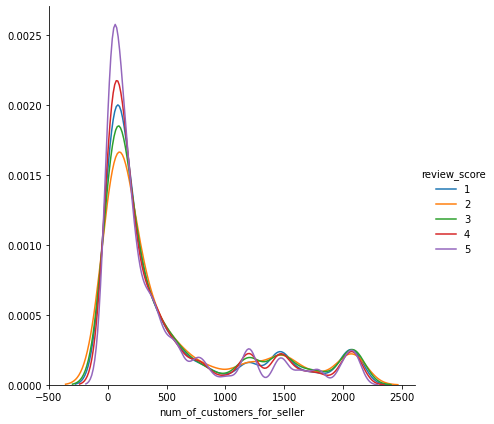

In [25]:
#num_of_customers_for_seller
sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"num_of_customers_for_seller")\
    .add_legend()
plt.show()

In [21]:
cust_tot = np.sum(df,axis=0)

num_sellers = []
for i in range(len(data)):
    num = cust_tot[data["customer_unique_id"][i]]
    num_sellers.append(num)

data["num_of_sellers_for_cust"] = num_sellers

In [22]:
# save the object to the file
filename = "dict_customer.pkl"
pickle.dump(cust_tot,open(filename,"wb"))

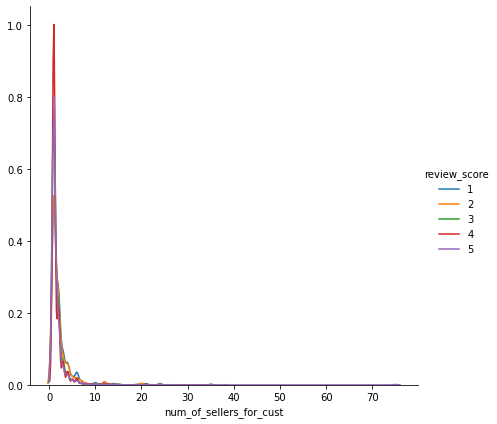

In [27]:
#similarity_using_cat
sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"num_of_sellers_for_cust")\
    .add_legend()
plt.show()

In [23]:
df = data.groupby("seller_id")["order_id"].value_counts().unstack()
df.fillna(0,inplace=True)
tot = np.sum(df,axis=1).to_dict()

In [24]:
# save the object to the file
filename = "dict_seller_order.pkl"
pickle.dump(tot,open(filename,"wb"))

In [25]:
num_orders = []
for i in range(len(data)):
    num = tot[data["seller_id"][i]]
    num_orders.append(num)

data["total_order_for_seller"] = num_orders

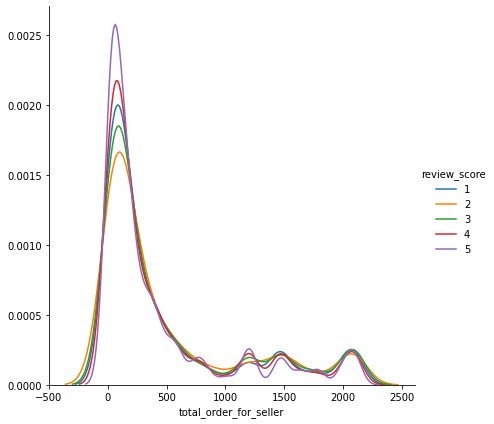

In [26]:
sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"total_order_for_seller")\
    .add_legend()
plt.show()

In [27]:
data.corr()["review_score"]

payment_sequential             0.007774
payment_installments          -0.043959
payment_value                 -0.083140
review_score                   1.000000
zip_code_prefix_customer      -0.027236
lat_customer                  -0.037309
lng_customer                  -0.042775
product_name_lenght           -0.013654
product_description_lenght     0.014226
product_photos_qty             0.021811
product_weight_g              -0.027676
product_length_cm             -0.020965
product_height_cm             -0.023773
product_width_cm              -0.012380
order_item_id                 -0.138087
price                          0.002252
freight_value                 -0.034503
zip_code_prefix_seller         0.026792
lat_seller                    -0.009388
lng_seller                     0.012411
estimated_time                -0.062526
actual_time                   -0.304973
diff_actual_estimated         -0.229065
diff_purchased_approved       -0.019166
diff_purchased_courrier       -0.152338


In [28]:
#saving all the created features with data.
data.to_csv("data_with_advanced_features.csv")